## Fetch the Data and Visualize Data

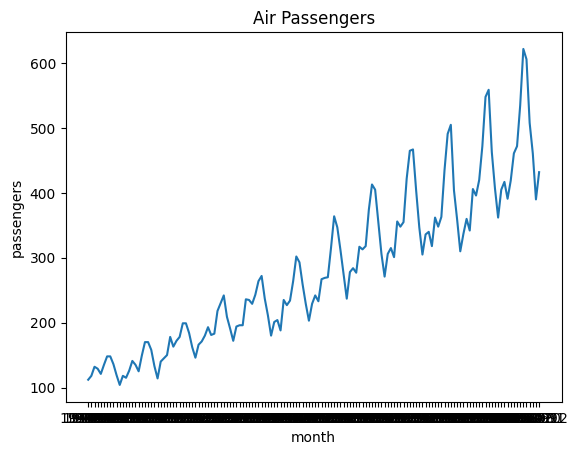

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Fetch Data
data = pd.read_csv('data-sets/air_passengers.csv')

month = data['Month']
passengers = data['Passengers']

plt.plot(month, passengers)
plt.xlabel('month')
plt.ylabel('passengers')
plt.title('Air Passengers')
plt.show()

## Clean trend and seasonality from data

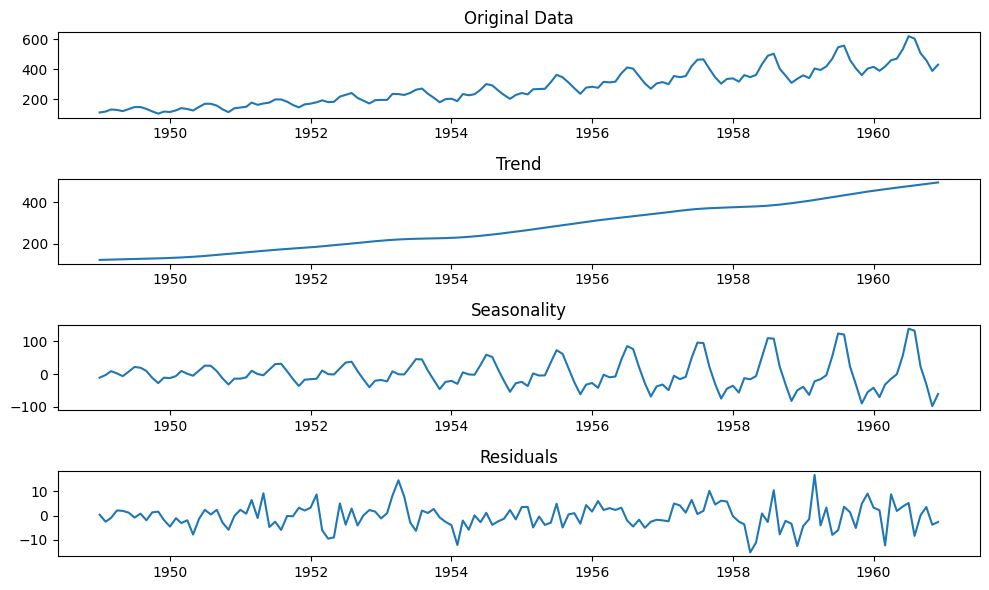

In [2]:
from statsmodels.tsa.seasonal import STL

# Assuming your data has a datetime column, set it as the index
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)

# Perform seasonal decomposition
decomp = STL(data).fit()

# Obtain the trend, seasonal, and residual components
trend = decomp.trend
seasonal = decomp.seasonal
residuals = decomp.resid

# Plot the original data, trend, and seasonality
plt.figure(figsize=(10, 6))

plt.subplot(4, 1, 1)
plt.plot(data)
plt.title('Original Data')

plt.subplot(4, 1, 2)
plt.plot(trend)
plt.title('Trend')

plt.subplot(4, 1, 3)
plt.plot(seasonal)
plt.title('Seasonality')

plt.subplot(4, 1, 4)
plt.plot(residuals)
plt.title('Residuals')

plt.tight_layout()
plt.show()

## We will continue with the residuals data

In [3]:
import numpy as np
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
import pandas as pd

# Fetch Data
data = pd.read_csv('data-sets/air_passengers.csv')

residuals_df = pd.DataFrame({'residuals': decomp.resid})
#residuals_df = residuals_df.round().astype(int)
residuals_df['t-1'] = residuals_df['residuals'].shift(1).values
residuals_df['t-2'] = residuals_df['residuals'].shift(2).values
data = data.dropna()
residuals_df = residuals_df.dropna()

data = data.drop('Passengers', axis=1)
#residuals_df['residuals'] = residuals_df['residuals'].astype(str)
residuals_df = residuals_df.drop(residuals_df.tail(2).index)
print(len(data))
print(len(residuals_df))

data = data.reset_index(drop=True)
residuals_df = residuals_df.reset_index(drop=True)

print(data.index)
print(residuals_df.index)



#data['residuals'] = pd.DataFrame({'residuals': decomp.resid})
#print(len(data['residuals']))
# data['residue'] = residuals
# Drop the NaN values created by shifting
data['residuals'] = residuals_df['residuals']
data['Month'] = pd.to_datetime(data['Month'])

144
140
RangeIndex(start=0, stop=144, step=1)
RangeIndex(start=0, stop=140, step=1)


In [4]:
train_ratio = 0.55
validation_ratio = 0.15
test_ratio = 0.30

# train is now 70% of the entire data set
train_data, temp = np.split(residuals_df, [int(train_ratio*len(residuals_df))])
print(len(train_data))
print(len(temp))


# temp is now 30% of the initial data set
# validation is now 15% of the initial data set
# test is now 15% of the initial data set
validation_data, test_data = np.split(temp, [int((1 - test_ratio)*len(temp))])
print(len(validation_data))
print(len(test_data))



77
63
44
19


In [5]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

X_train = train_data[['t-1', 't-2']]
y_train = train_data['residuals']

model = svm.SVR()

BayesSearch

In [12]:
from sklearn.model_selection import KFold
from skopt import BayesSearchCV
from skopt.plots import plot_objective, plot_histogram



# Define hyperparameters for bayesian optimization
param_space = {
    'C': (1e-12, 1e+1, 'log-uniform'),
    'gamma': (1e-20, 1e+1, 'log-uniform'),
    'epsilon': (1e-6, 1e+6, 'log-uniform'),
    # 'kernel': ('sigmoid', 'poly', 'rbf'),  # categorical parameter
    }


kFold = KFold(n_splits=5, shuffle=True, random_state=42)

model.fit(X_train, y_train)

bayes_search = BayesSearchCV(estimator=model, search_spaces=param_space, cv= kFold, 
                             scoring='neg_mean_absolute_percentage_error', n_iter=20)

bayes_search.fit(X_train, y_train)

# Print the cross validation results
cv_results = bayes_search.cv_results_
cv_results_df = pd.DataFrame(cv_results)

cv_results_df['C'] = cv_results_df['params'].apply(lambda x: x['C'])
cv_results_df['gamma'] = cv_results_df['params'].apply(lambda x: x['gamma'])
cv_results_df['epsilon'] = cv_results_df['params'].apply(lambda x: x['epsilon'])

print(cv_results_df[['mean_test_score', 'C', 'gamma', 'epsilon']])

# plot_objective creates pairwise dependence plot of the objective function.
# plot_objective(bayes_search.optimizer_results_[0],
#                    dimensions=["C", "gamma", "epsilon"],
#                    n_minimum_search=int(1e8))

# Print the best hyperparameters
print('Best hyperparameters:', bayes_search.best_params_)

best_model = bayes_search.best_estimator_


    mean_test_score             C         gamma       epsilon
0         -1.315810  6.998518e-04  2.140685e-10      0.001330
1         -1.315810  2.439651e-07  1.308370e-07      0.012624
2         -1.315810  9.120655e-08  2.228863e-07      0.000016
3         -1.315810  1.416791e-11  4.492747e-12      0.001591
4         -1.315810  1.150279e-09  4.247234e-07      0.001233
5         -1.977570  7.275557e-07  2.117361e-10  35277.398887
6         -1.310529  1.418948e+00  1.412014e+00      8.677209
7         -1.316141  4.519071e-03  1.840698e-01      0.000007
8         -1.317243  1.252576e-08  3.906333e-18      0.075736
9         -1.318170  6.043132e-11  2.334317e-04      3.016845
10        -1.315810  1.000000e-12  1.000000e-20      0.000001
11        -1.315810  1.000000e+01  1.000000e-20      0.000146
12        -1.977570  1.000000e-12  1.000000e-20     14.856938
13        -1.403808  1.000000e+01  1.000000e+01      0.645562
14        -1.315842  1.000000e+01  7.833113e-08      0.000001
15      

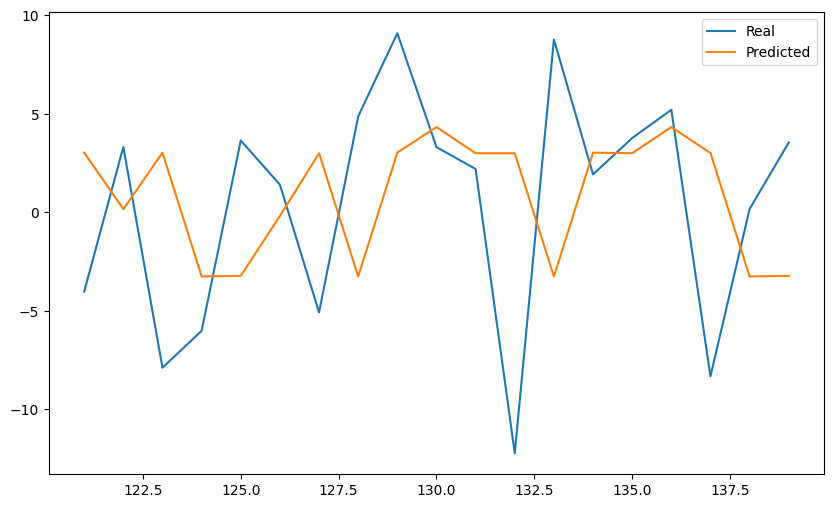

In [19]:
import matplotlib.pyplot as plt

X_test = test_data[['t-1', 't-2']]
y_test = test_data['residuals']

best_model.kernel = 'sigmoid'
y_pred = best_model.predict(X_test)

# Plotting
plt.figure(figsize=(10,6))
plt.plot(y_test.index, y_test.values, label='Real')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

19
19
           t-1        t-2
121  16.725203  -1.433981
122  -4.027086  16.725203
123   3.311023  -4.027086
124  -7.892238   3.311023
125  -6.017385  -7.892238
126   3.641203  -6.017385
127   1.398313   3.641203
128  -5.081090   1.398313
129   4.862860  -5.081090
130   9.081611   4.862860
131   3.304185   9.081611
132   2.193415   3.304185
133 -12.234409   2.193415
134   8.766614 -12.234409
135   1.918945   8.766614
136   3.763704   1.918945
137   5.198703   3.763704
138  -8.327198   5.198703
139   0.163900  -8.327198
[453.26180853 424.57003499 463.28772671 480.60562314 494.78979897
 552.29949955 634.23866714 628.16111072 518.09178236 464.16360072
 396.91946921 434.26407435 453.26180853 424.57003499 463.28772671
 480.60562314 494.78979897 552.29949955 634.23866714]


ValueError: x and y must have same first dimension, but have shapes (125,) and (19,)

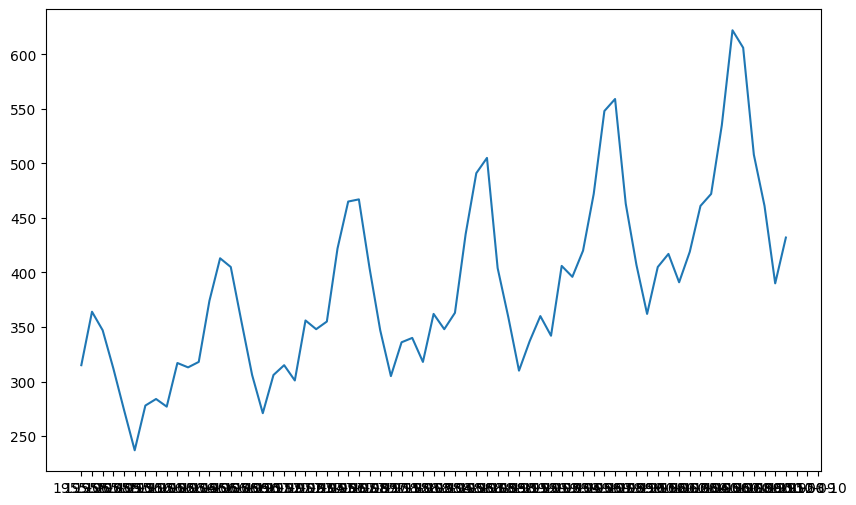

In [8]:
# Assuming that your seasonality is yearly (12 months)
seasonal_period = 12 

# Extend the last known value of the trend into the future.
last_known_trend = trend[-1]
trend_test = np.full(len(X_test), last_known_trend)

# Repeat the last complete seasonal cycle for future periods.
last_seasonal_cycle = seasonal[-seasonal_period:]
seasonal_test = np.tile(last_seasonal_cycle, len(X_test) // seasonal_period + 1)[:len(X_test)]


# Predict residuals
y_pred_resid = best_model.predict(X_test)

# Add back the trend and seasonal components.
y_pred = y_pred_resid + trend_test + seasonal_test

print(len(X_test))  # number of test examples
print(len(y_pred))  # number of predictions

print(X_test)
print(y_pred)


# Plotting
plt.figure(figsize=(10,6))
plt.plot(month[len(X_train):], passengers[len(X_train):], label='Real')
plt.plot(month[len(X_test):], y_pred, label='Predicted')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print('Mean Squared Error on test set:', mse)
